In [1]:
import sys
sys.path.append("../..")

# Noisy Pendulum - Statistically Linearized Filter Example

Estimate pendulum state with Particle Filter and Backward-simulation Particle Smoother as in Examples 7.1 and 11.1 of the book Bayesian Filtering and Smoothing


## Imports

### Standard imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg, stats
import tqdm

### Helpers imports

In [3]:
from python.common_utilities import generate_pendulum, RandomState, rmse

### Plotting function

In [4]:
def plot(timeline, y, x1, label1, x2=None, label2=None):
    fig, axes = plt.subplots(ncols=2, figsize=(22, 10))
    axes[1].scatter(timeline, y, marker="o", label="Measurements", color="red", alpha=0.66)
    axes[1].plot(timeline, np.sin(x1[:, 0]), linestyle="dashdot", label=label1, color="blue")
                    
    axes[0].plot(x1[:, 0], x1[:, 1], label=label1, color="blue")
    
    if x2 is not None:
        axes[1].plot(timeline, np.sin(x2[:, 0]), linestyle="dashdot", label=label2, color="orange")
        axes[0].plot(x2[:, 0], x2[:, 1], label=label2, color="orange")
    else:
        axes[0].scatter(x1[0, 0], x1[0, 1], marker="x", color="orange", s=500)
        
    axes[0].set_xlabel("$x_0(t)$")
    axes[0].set_ylabel("$x_1(t)$")
    
    axes[1].set_xlabel("$t$")
    axes[1].set_ylabel("$\sin(x_0(t))$")
    
    axes[0].legend()
    axes[1].legend()


## Routine

Set the parameters:

In [5]:
dt = 0.01
g  = 9.81

In [6]:
Q  = 0.01 * np.array([[dt ** 3 / 3, dt ** 2 / 2], 
                       [dt ** 2 / 2, dt]])
R  = 0.1

In [7]:
x_0 = np.array([1.5, 0.])

## Simulate data

In [8]:
random_state = RandomState(1)
steps = 500

timeline, states, observations = generate_pendulum(x_0, g, Q, dt, R, steps, random_state)

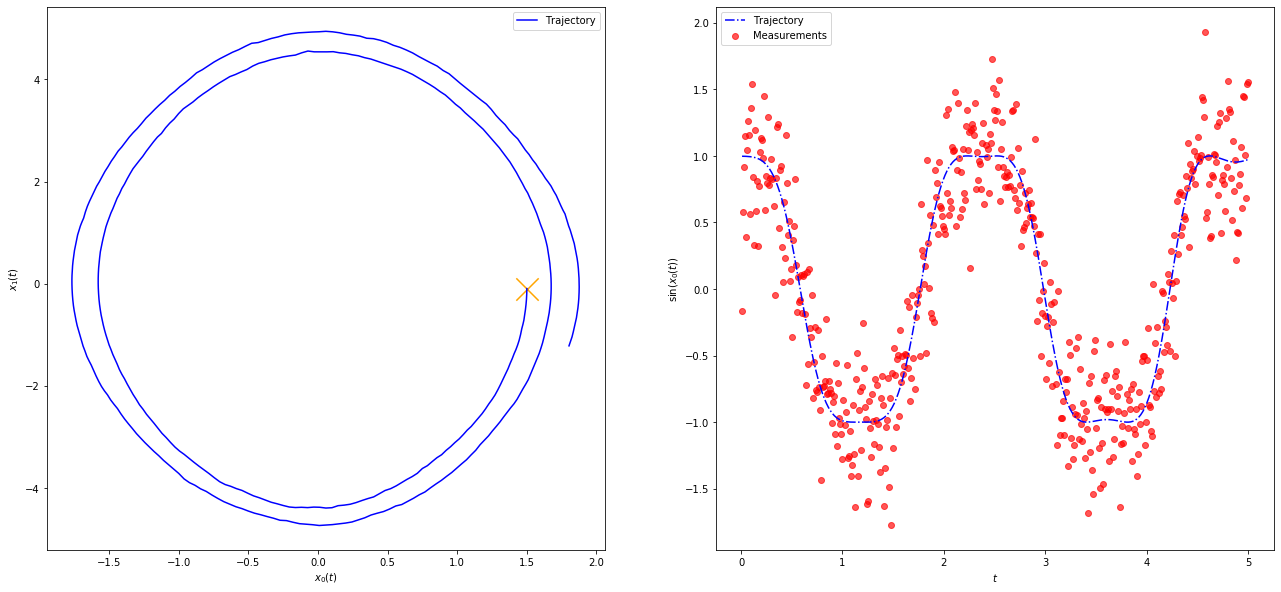

In [9]:
plot(timeline, observations, states, "Trajectory")

## Extended Kalman Filter

In [10]:
m_0 = np.array([1.6, 0.])  # Slightly off
P_0 = np.array([[0.1, 0.], 
                [0., 0.1]])

In [13]:
def linearized_kalman_filter(m_0, P_0, g, Q, dt, R, observations):
    M = m_0.shape[-1]
    steps = observations.shape[0]
    
    slf_m = np.empty((steps, M))
    slf_P = np.empty((steps, M, M))
    
    m = m_0[:]
    P = P_0[:]

    for i in range(steps):
        observation = observations[i]
        # Expected covariance of the prediction
        temp = np.exp(-P[0, 0] / 2)
        e_P = np.array([[P[0, 0] + dt * P[0, 1], P[0, 1] + dt * P[1, 1]],
                        [P[0, 1] - g * dt * np.cos(m[0]) * P[0, 0] * temp, P[1, 1] - g * dt * np.cos(m[0]) * P[0, 1] * temp]])
        
        # Expected mean of the prediction
        m[0], m[1] = m[0] + dt * m[1], m[1] - g * dt * np.sin(m[0]) * temp
        
        # Linearized Covariance of the prediction
        P = e_P @ linalg.solve(P, e_P.T, assume_a="pos") + Q
        
        # Expected predicted observation
        temp = np.exp(-P[0, 0] / 2)
        
        h = np.sin(m[0]) * temp
        H = temp * np.array([[np.cos(m[0]) * P[0, 0], np.cos(m[0]) * P[0, 1]]])
        
        S = H.dot(linalg.solve(P, H.T, assume_a="pos")) + R
        
        # Gain
        K = linalg.solve(S, H, assume_a="pos").T 
        # More efficient and stable way of computing K = H.T @ linalg.inv(S)
        # This also leverages the fact that S is known to be a symmetric positive definite matrix (assume_a="pos")
        m = m + K @ np.atleast_1d(observation - h)
        P = P - K @ S @ K.T
        
        slf_m[i] = m
        slf_P[i] = P
    return slf_m, slf_P

In [14]:
slf_m, slf_P = linearized_kalman_filter(m_0, P_0, g, Q, dt, R, observations)

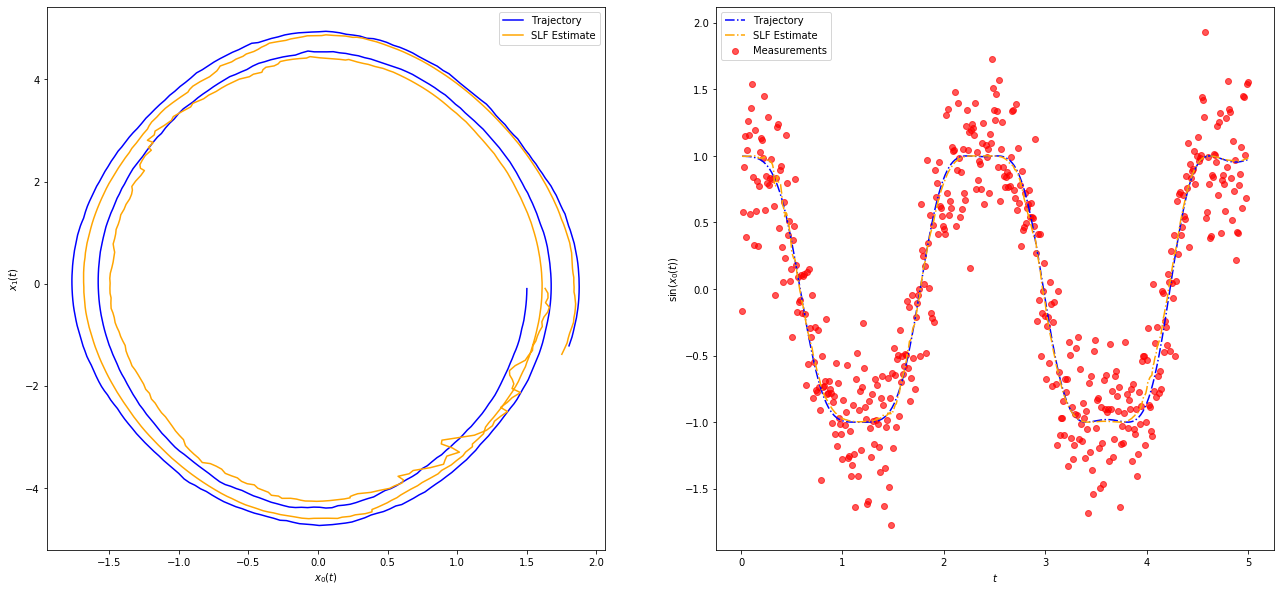

In [15]:
plot(timeline, observations, states, "Trajectory", slf_m, "SLF Estimate")

In [16]:
rmse_slf = rmse(slf_m[:, :1], states[:, :1])
print(f"SLF RMSE: {rmse_slf}")

SLF RMSE: 0.07639379043921098


## Linearized RTS

In [17]:
def linearized_smoother(slf_m, slf_P, g, Q, dt, R):
    
    steps, M = slf_m.shape
    
    rts_m = np.empty((steps, M))
    rts_P = np.empty((steps, M, M))
    
    m = slf_m[-1][:]
    P = slf_P[-1][:]
    
    rts_m[-1] = m
    rts_P[-1] = P
    
    for i in range(steps-2, -1, -1):

        filtered_m = slf_m[i]
        filtered_P = slf_P[i]
        
        
        temp = np.exp(-filtered_P[0, 0] / 2)
        e_P = np.array([[filtered_P[0, 0] + dt * filtered_P[0, 1], 
                         filtered_P[0, 1] + dt * filtered_P[1, 1]],
                        [filtered_P[0, 1] - g * dt * np.cos(filtered_m[0]) * filtered_P[0, 0] * temp, 
                         filtered_P[1, 1] - g * dt * np.cos(filtered_m[0]) * filtered_P[0, 1] * temp]])
        
        mp = np.array([filtered_m[0] + dt * filtered_m[1], filtered_m[1] - g * dt * np.sin(filtered_m[0]) * temp])
        Pp = e_P @ linalg.solve(filtered_P, e_P.T, assume_a="pos") + Q

        Ck = linalg.solve(Pp, e_P, assume_a="pos").T 
        # More efficient and stable way of computing Ck = e_P.T @ linalg.inv(Pp)
        # This also leverages the fact that Pp is known to be a symmetric positive definite matrix (assume_a="pos")
        
        m = filtered_m + Ck @ (m - mp)
        P = filtered_P + Ck @ (P - Pp) @ Ck.T
        
        rts_m[i] = m
        rts_P[i] = P

    return rts_m, rts_P


In [18]:
rts_m, rts_P = linearized_smoother(slf_m, slf_P, g, Q, dt, R)

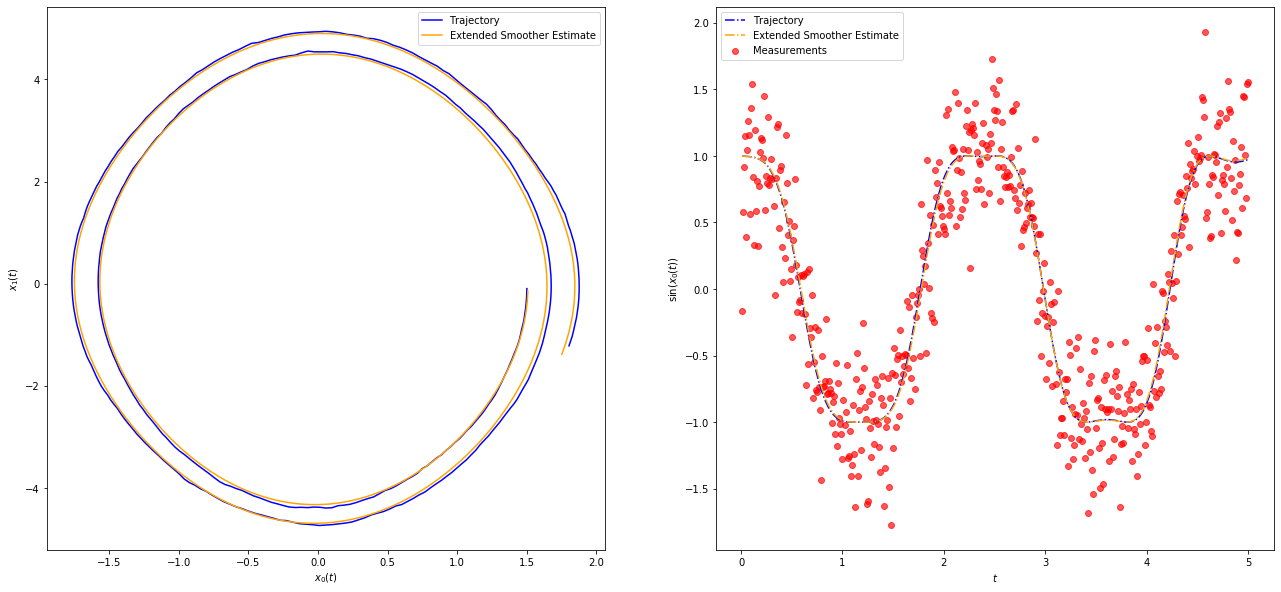

In [19]:
plot(timeline, observations, states, "Trajectory", rts_m, "Extended Smoother Estimate")

In [20]:
rmse_lrts = rmse(rts_m[:, :1], states[:, :1])
print(f"LRTS RMSE: {rmse_lrts}")

LRTS RMSE: 0.027366789674858158
